In [37]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [38]:
#Store the data into the df variable
SYMBOL = 'ETH'
df = pd.read_csv(f'../../data/{SYMBOL}.csv')

In [39]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values)).tail(5000)
df['price'] = df[['high_price','low_price']].mean(axis=1)
#Show the dataframe
# df

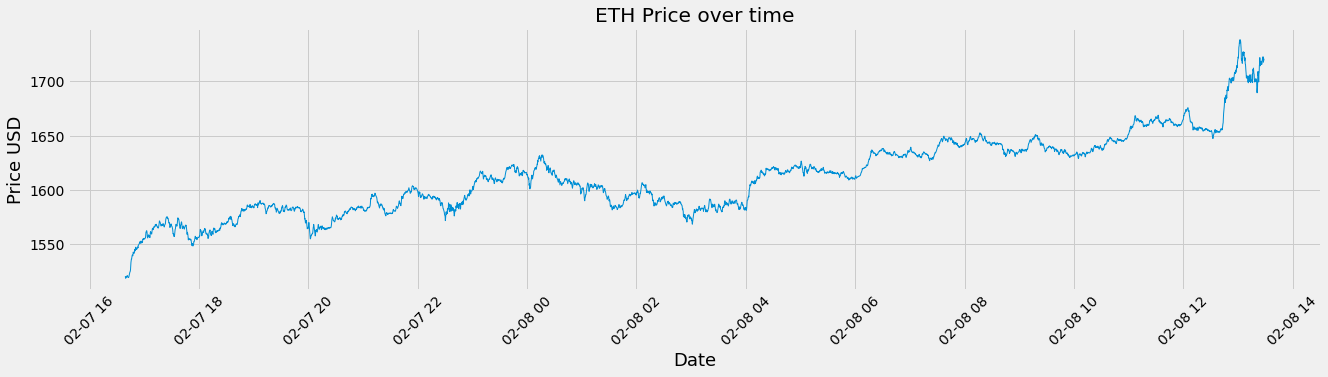

In [40]:
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.title(f"{SYMBOL} Price over time")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD',fontsize=18)
plt.show()

In [41]:

def createMacdAndSignalLines(dataset, macd_params, macd_multiplier):
    ShortEMA = dataset.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = dataset.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*round(1+macd_multiplier*.25), adjust=False).mean()
    return (Macd.price, signal.price)

macd_params = (12, 26, 9)
macd_multiplier = 49
# Best Multipliers for coins:
# ----------------------------
# ETH: 175, 178, 16, 49
# BCH: 50, 692
# LTC: none
smoothed_df = df.price.ewm(span=20, adjust=False).mean() #AKA Slow moving average
macd, signal = createMacdAndSignalLines(df, macd_params, macd_multiplier)

In [42]:
df['MACD'] = macd
df['Signal Line'] = signal

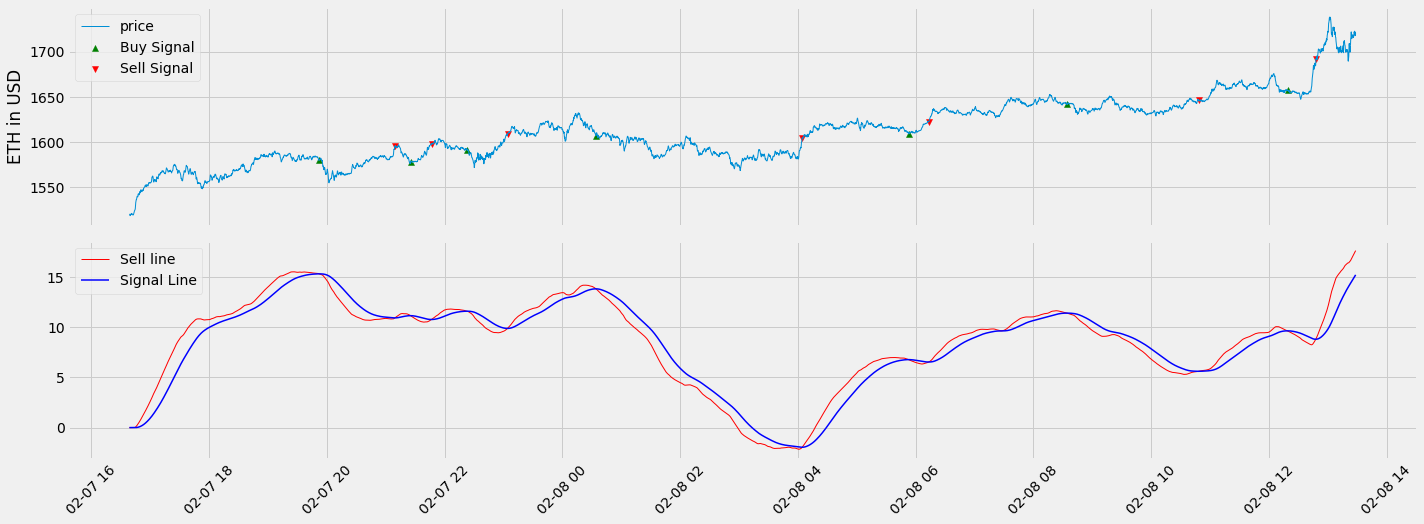

2021-02-07T21:09:30Z Bought at 1573.49. Selling at 1595.72. Profit: +21.22
2021-02-07T21:46:45Z Bought at 1576.74. Selling at 1597.61. Profit: +19.86
2021-02-07T23:04:15Z Bought at 1591.69. Selling at 1608.99. Profit: +16.29
2021-02-08T04:04:30Z Bought at 1612.45. Selling at 1604.74. Profit: -8.71
2021-02-08T06:13:30Z Bought at 1614.29. Selling at 1622.21. Profit: +6.92
2021-02-08T10:48:30Z Bought at 1643.29. Selling at 1646.34. Profit: +2.05
2021-02-08T12:48:00Z Bought at 1657.10. Selling at 1691.97. Profit: +33.87
Profit 91.50019400000065
Transactions:  7


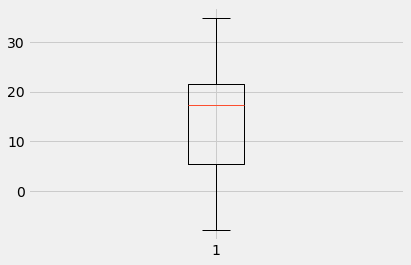

In [43]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(50, len(df)):
        if (bought == False and getBuySignal(df, i)):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if (bought and getSellSignal(df, i, bought)):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], f"Bought at {bought:.2f}. Selling at {df['price'].iat[i]:.2f}. Profit: {df['price'].iat[i] - bought - 1:+.2f}")
            
            transactions.append(df['price'].iat[i] - bought)
            sumwin = sumwin + df['price'].iat[i] - bought - 1
            bought = False 
    return(sumwin, transactions)

def getBuySignal(df, i):
  return (df['MACD'].iat[i] < df['Signal Line'].iat[i]) and (df['MACD'].iat[i-1] >= df['Signal Line'].iat[i-1])
def getSellSignal(df, i, bought_price):
  # if bought_price >= df['price'][i]:
    # return False
  # else:
    # return (df["MACD_sell"].diff().iat[i] < 0.05)
  return (df['MACD'].iat[i] > df['Signal Line'].iat[i]) and (df['MACD'].iat[i-1] <= df['Signal Line'].iat[i-1])

#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  bought = False
  for i in range(0,len(df)):
    if i < 50:
      sigPriceBuy.append(np.nan)
      sigPriceSell.append(np.nan)
    else:
    #if MACD > signal line  then buy else sell
      if getBuySignal(signal, i):
        if not bought:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          bought = signal['price'][i]
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif getSellSignal(signal, i, bought): 
        if bought != False:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          bought = False
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
df['Buy_Signal_Price'], df['Sell_Signal_Price'] = buy_sell(df)

fig, axs = plt.subplots(2, figsize=(20, 7.5), sharex=True)
plt.xticks(rotation=45)
axs[0].plot( df['price'],  label='price', linewidth=1)
axs[0].scatter(df.index, df['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
axs[0].legend(loc='upper left')
axs[0].set_ylabel('ETH in USD')
axs[1].plot(df.index, df['MACD'], label='Sell line', color = 'red', linewidth=1)
axs[1].plot(df.index, df['Signal Line'], label='Signal Line', color='blue', linewidth=1.5)
axs[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

r = mac_daddy_tester(df)
print("Profit", r[0])
print("Transactions: ", len(r[1]))
plt.boxplot(r[1])
plt.show()

Profit: $154.98 Period Param: 70 Transactions: 6
Profit: $152.79 Period Param: 65 Transactions: 7
Profit: $150.79 Period Param: 71 Transactions: 6
Profit: $147.16 Period Param: 69 Transactions: 6
Profit: $146.44 Period Param: 68 Transactions: 6
Profit: $141.95 Period Param: 66 Transactions: 6
Profit: $141.85 Period Param: 59 Transactions: 7
Profit: $140.38 Period Param: 67 Transactions: 6
Profit: $137.65 Period Param: 64 Transactions: 7
Profit: $135.83 Period Param: 58 Transactions: 7
Profit: $133.57 Period Param: 28 Transactions: 16
Profit: $132.59 Period Param: 60 Transactions: 7
Profit: $130.66 Period Param: 76 Transactions: 6
Profit: $128.79 Period Param: 63 Transactions: 7
Profit: $128.21 Period Param: 62 Transactions: 7
Profit: $127.22 Period Param: 92 Transactions: 5
Profit: $125.51 Period Param: 26 Transactions: 15
Profit: $124.80 Period Param: 29 Transactions: 16
Profit: $124.71 Period Param: 81 Transactions: 6
Profit: $124.59 Period Param: 93 Transactions: 5
Profit: $122.35 P

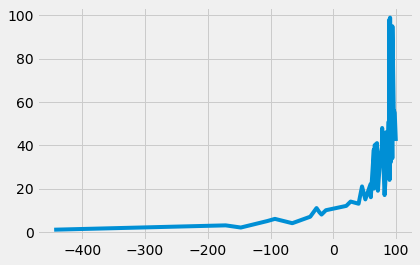

In [44]:
# Find optimal period value:
run_cell = True
# df.drop(columns=["MACD", "Signal Line"])
if run_cell:
    results = []
    for period_length in np.arange(1, 100, 1):

        macd_multiplier = period_length #was 111
        macd_params = (12, 26, 9)
        macd, signal = createMacdAndSignalLines(df, macd_params, macd_multiplier)
        df1 = df
        df1["MACD"] = macd
        df1["Signal Line"] = signal
        # print(df)
        r = mac_daddy_tester(df1, quiet=True)
        results.append((period_length, r[0], len(r[1])))
        # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))

    results.sort(key = lambda x: -x[1])
    dist = pd.DataFrame(results[50:], columns =['Period', 'Profit', 'Transactions'])
    for tup in results[:25]:
        print(f"Profit: ${tup[1]:.2f} Period Param: {tup[0]} Transactions: {tup[2]}")
    plt.plot(dist["Profit"], dist["Period"])

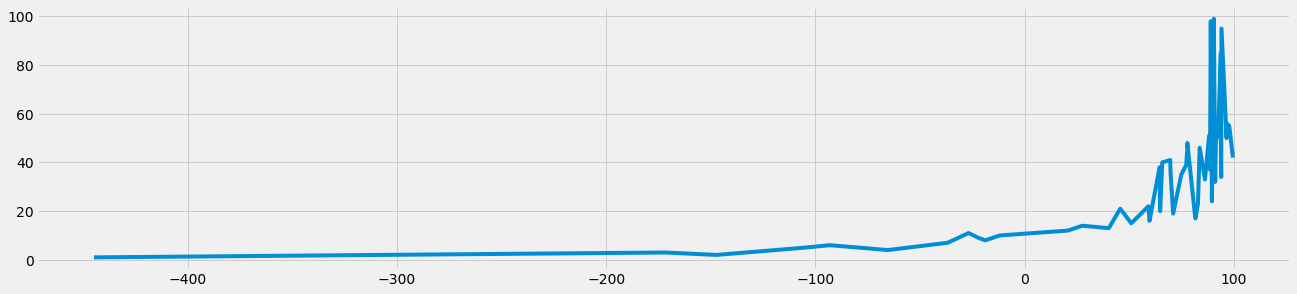

In [45]:
plt.figure(figsize=(20,4.5))
plt.plot(dist["Profit"],dist["Period"])

# Best results
using (12, 26, 9) a multiplier of 20, 21, 18, 28, 35 seems Best

using (12, 26, 9) but with a round(multiplier*0.1) on the signal 49, 57, 50, 56 is Best ($180)

using (12, 26, 9) but with a round(multiplier*0.25) on the signal period multipliers of 47, 48, 49, 50 is Best ($275)